In [62]:
# convolucao 1d usando torch

import torch
from torch import nn
import torch.nn.functional as F

# sinal
x = torch.tensor([5, 4, 8, 7, 9, 3, 6], dtype=torch.float32)

# filtro
weight = torch.tensor([1, 2, 3], dtype=torch.float32)

ks = len(weight)

# redimensiona sinal para 1x1xlen(x) pois representa um batch de um sinal de tamanho len(x)
x = x.reshape(1, 1, len(x))

# Redimensiona o filtro. O primeiro valor 1 possui um significado diferente do que
# no caso do sinal. Depois será explicado.
weight = weight.reshape(1,1,len(weight))
# Realiza a convolução
# lembrar que convolucao eh deslizar array de baixo no de cima multiplicando e somando
y = F.conv1d(x, weight)

# shape mostra apenas 5 valores, porque ele nao faz preenchimento de borda manualmente
print(y.shape)
print(y)

torch.Size([1, 1, 5])
tensor([[[37., 41., 49., 34., 33.]]])


In [63]:
# para garantir que sinal de saida tenha mesmo tamanho do sinal de entrada, usar padding de ks//2, sendo ks o tamanho do filtro
y = F.conv1d(x, weight, padding=ks//2) # funcao que aplica convolucao 
y

tensor([[[22., 37., 41., 49., 34., 33., 15.]]])

In [64]:
# em redes neurais, bias eh um valor constante adicionado ao resultado
# [5.] pois para broadcasting tensor deve ter dimensao 1 pelo menos
bias = torch.tensor([5.])
print(bias.shape)

y_with_bias = F.conv1d(x, weight, padding=ks//2, bias=bias)
y_with_bias

torch.Size([1])


tensor([[[27., 42., 46., 54., 39., 38., 20.]]])

In [65]:
# camada de convolucao

# cria camada de convolucao, similar com criacao de camadas de modelo (eg Linear)
# difere do codigo em cima que funcao convolucao eh executada
# nesse caso gera um filtro aleatorio de tamanho ks
ks = 3
conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=ks, padding=ks//2, bias=False)

y = conv(x)
y

tensor([[[0.3622, 4.2110, 2.7924, 5.5603, 3.0272, 5.8380, 0.5970]]],
       grad_fn=<ConvolutionBackward0>)

In [66]:
# filtro criado tem requires_grad  = True por default
print(conv.weight)
# para mudar filtro, faz-se:
weight = torch.tensor([1, 2, 3], dtype=torch.float32)
with torch.no_grad():
    conv.weight[:] = weight

conv(x)

Parameter containing:
tensor([[[ 0.5104, -0.1557,  0.2852]]], requires_grad=True)


tensor([[[22., 37., 41., 49., 34., 33., 15.]]], grad_fn=<ConvolutionBackward0>)

In [67]:
# relacao entre combinacao linear e convolucao linear
# o codigo abaixo mostra que a convolucao nada mais eh do que uma combinacao linear feita de maneira mais simples, com menos 
# valores na matriz
# a matriz abaixo simula o deslocamento do vetor de pesos
# a linha 0 fará a operação 2*x[0]+3*x[1]+0*x[2]+...
matrix = torch.tensor([[2, 3, 0, 0, 0, 0, 0],
                       [1, 2, 3, 0, 0, 0, 0],
                       [0, 1, 2, 3, 0, 0, 0],
                       [0, 0, 1, 2, 3, 0, 0],
                       [0, 0, 0, 1, 2, 3, 0],
                       [0, 0, 0, 0, 1, 2, 3],
                       [0, 0, 0, 0, 0, 1, 2]], dtype=torch.float32)

F.linear(x, matrix)

tensor([[[22., 37., 41., 49., 34., 33., 15.]]])

In [68]:
# convolucao com mais de um canal
# geracao de um batch de um sinal de tamanho 7 e com 4 canais
x = torch.rand(size=(1, 4, 7))

# out_channels define o numero de filtros utilizados na camada de convolucao
# maneira de convolucionar mesmos dados com filtros diferentes
conv = nn.Conv1d(in_channels=4, out_channels=5, kernel_size=ks, padding=ks//2, bias=False)

conv(x)

print(x)
print('\n')
# y tem tamanho 1x5x7
y = conv(x)
print(y)


tensor([[[0.0412, 0.0896, 0.3672, 0.6138, 0.5690, 0.9119, 0.2683],
         [0.0125, 0.6953, 0.5401, 0.9501, 0.8471, 0.4558, 0.2991],
         [0.8564, 0.1473, 0.7746, 0.9480, 0.6738, 0.0984, 0.4759],
         [0.7339, 0.6039, 0.4272, 0.5361, 0.7002, 0.4054, 0.8566]]])


tensor([[[-0.3012,  0.0908, -0.1498, -0.0618,  0.1232,  0.2504,  0.0094],
         [ 0.2975,  0.2956,  0.6017,  0.3225,  0.3779,  0.3245,  0.1042],
         [ 0.0258,  0.4991,  0.3248,  0.5401,  0.8174,  0.7346,  0.4190],
         [ 0.3353,  0.0790,  0.3289,  0.3117,  0.2556,  0.2877,  0.2165],
         [ 0.2648,  0.2073,  0.1390,  0.4727,  0.5569,  0.3165,  0.2723]]],
       grad_fn=<ConvolutionBackward0>)


In [69]:
print(conv.weight[0])
print(y[0, 0, 1])
print(x[0, :, 0:3])

# matriz deslizando na primeira linha da saida y, na posicao de saida y[0, 0, 2]
filtro1 = conv.weight[0]
regiao = x[0, :, 1:4]
res = (filtro1*regiao).sum()

print(torch.allclose(res, y[0, 0, 2]))

# matriz deslizando na ultima linha da saida y, na posicao de saida y[0, 4, 1]
filtro5 = conv.weight[4]
regiao = x[0, :, 2:5]
res = (filtro5*regiao).sum()

print(torch.allclose(res, y[0, 4, 3]))

# na matriz x, todas linhas sao sempre usadas, porem para cada posicao de y apenas uma parte das colunas participa
# lembrar do deslizamento que acontece, e que em y[0, 0, 0] uma coluna do filtro eh "perdida" pois multiplica zeros do x (usando padding) -> em padding=ks//2

tensor([[-0.1569,  0.2812, -0.0320],
        [ 0.1873, -0.0236, -0.2005],
        [ 0.2373, -0.2872,  0.1770],
        [-0.1990,  0.2250, -0.1913]], grad_fn=<SelectBackward0>)
tensor(0.0908, grad_fn=<SelectBackward0>)
tensor([[0.0412, 0.0896, 0.3672],
        [0.0125, 0.6953, 0.5401],
        [0.8564, 0.1473, 0.7746],
        [0.7339, 0.6039, 0.4272]])
True
True


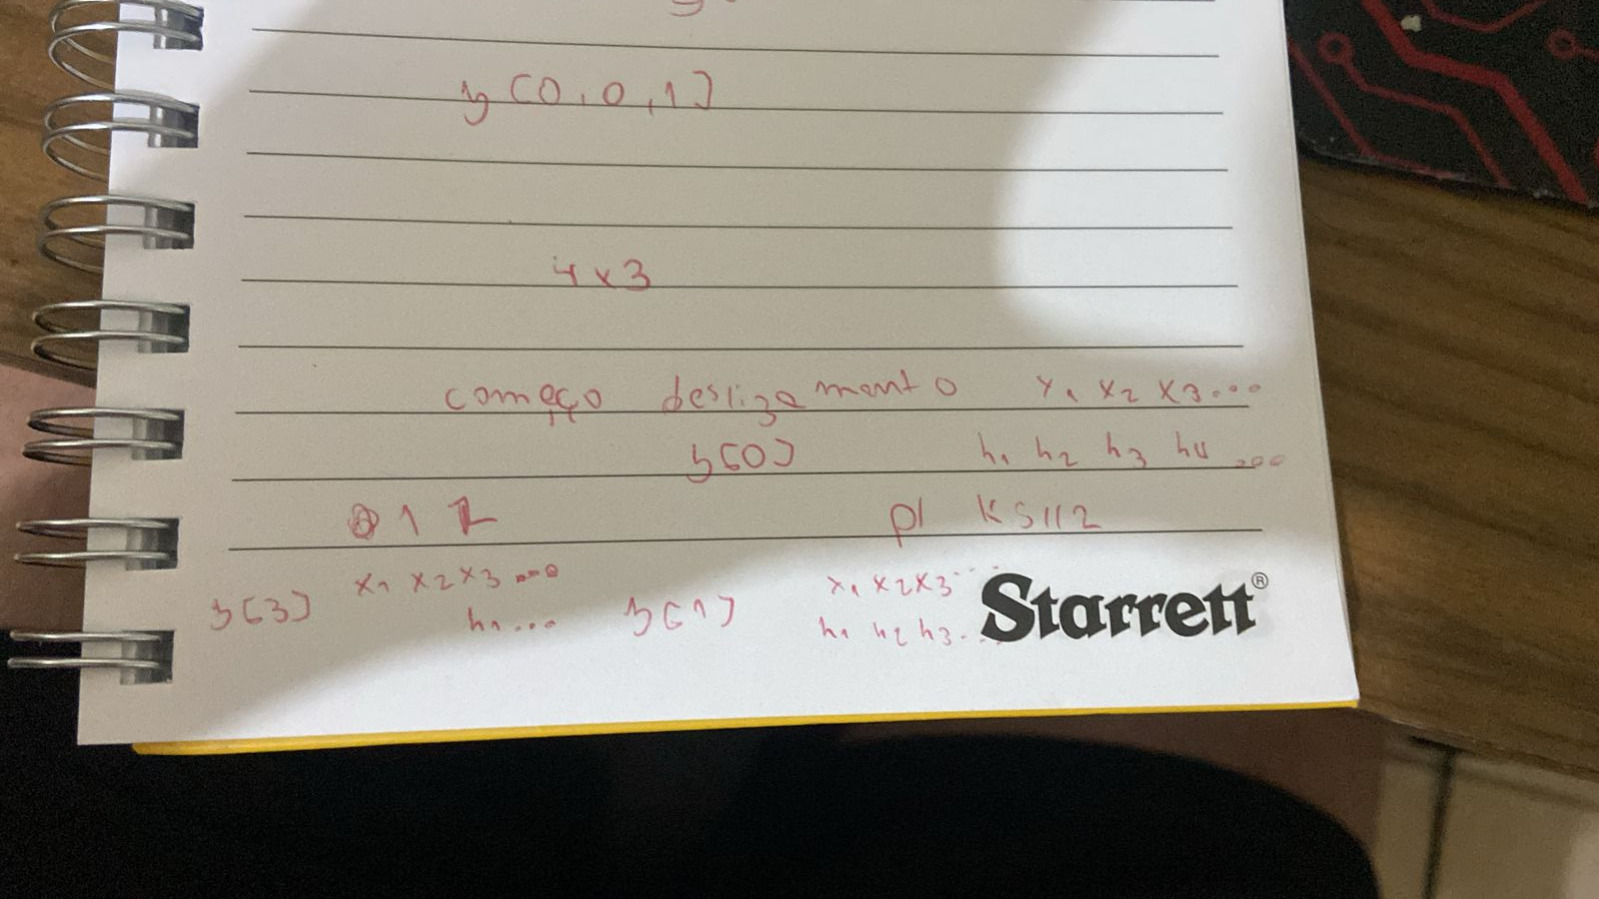

In [70]:
# outros parametros da convolucao


In [71]:
# stride: define a quantidade de deslocamento do filtro para cada posicao na qual a convolucao sera calculada 

x = torch.tensor([5, 4, 8, 7, 9, 3, 6], dtype=torch.float32)
w = torch.tensor([1, 2, 3], dtype=torch.float32)
x = x.reshape(1,1, len(x))
w = w.reshape(1, 1, len(w))

conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=ks, padding=ks//2, stride=2, bias=False)

with torch.no_grad():
    conv.weight[:] = w
# eh a mesma coisa que aplicar com stride 1 e pular valores de 2 em 2
y = F.conv1d(x, w, padding=ks//2, stride=2)
y

tensor([[[22., 41., 34., 15.]]])

In [79]:
# dilatacao: aumenta tamanho do filtro sem aumentar numero de parametros

# consiste em preencher valores 0 entre os valores do filtro

y  = F.conv1d(x, w, dilation=2)
wt = torch.tensor([1, 0, 2, 0, 3], dtype=torch.float32).reshape(1, 1, -1) # nesse caso -1 se refere a ultima dimensao
print(wt.shape)
# wt = wt.reshape(1, 1, len(wt))
yt = F.conv1d(x, wt)
y, yt

torch.Size([1, 1, 5])


(tensor([[[48., 27., 44.]]]), tensor([[[48., 27., 44.]]]))